In [1]:
# !pip install triton==2.0.0 --quiet


In [2]:
# ===================================================================
# CELL 0: SETUP OUTPUT DIRECTORIES
# ===================================================================
import os

# Create base directories for all outputs to keep the workspace clean
os.makedirs('/kaggle/working/gan_outputs', exist_ok=True)
os.makedirs('/kaggle/working/classifier_outputs', exist_ok=True)
os.makedirs('/kaggle/working/xai_outputs', exist_ok=True)
os.makedirs('/kaggle/working/llm_outputs', exist_ok=True)

print("Created output directories for GAN, Classifier, XAI, and LLM.")

Created output directories for GAN, Classifier, XAI, and LLM.


Using device: cuda

Loading and CLEANING dataset for cGAN training...
Using 40677 clean samples for cGAN training.
Class distribution - Class 0: 24098, Class 1: 16579
Normalizing data...
Prepared DataLoader for improved cGAN.

Starting V6 cWGAN-GP training with ResNet generator...


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/5], D Loss: -6.2802, G Loss: 1.9835, Lambda GP: 0.10
  Quality - PSD MSE: 0.00000008
Epoch [2/5], D Loss: -2.9265, G Loss: 4.2214, Lambda GP: 0.30
  Quality - PSD MSE: 0.00000005
Epoch [3/5], D Loss: -2.1547, G Loss: 3.3123, Lambda GP: 0.50
  Quality - PSD MSE: 0.00000006
Epoch [4/5], D Loss: -1.3651, G Loss: 2.2786, Lambda GP: 0.69
  Quality - PSD MSE: 0.00000001
Epoch [5/5], D Loss: -1.2004, G Loss: 0.6522, Lambda GP: 0.89
  Quality - PSD MSE: 0.00000000


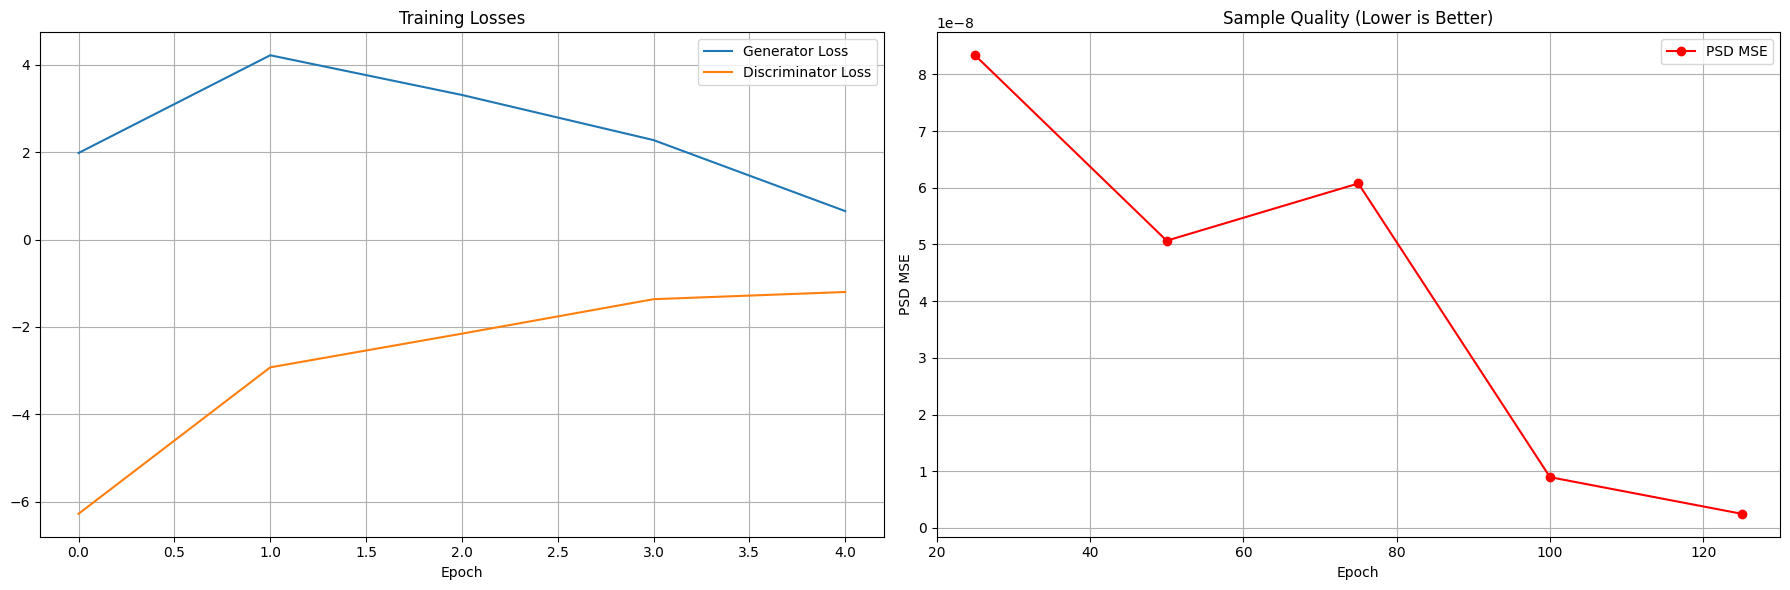


Visual comparison of Real vs. Generated Samples:


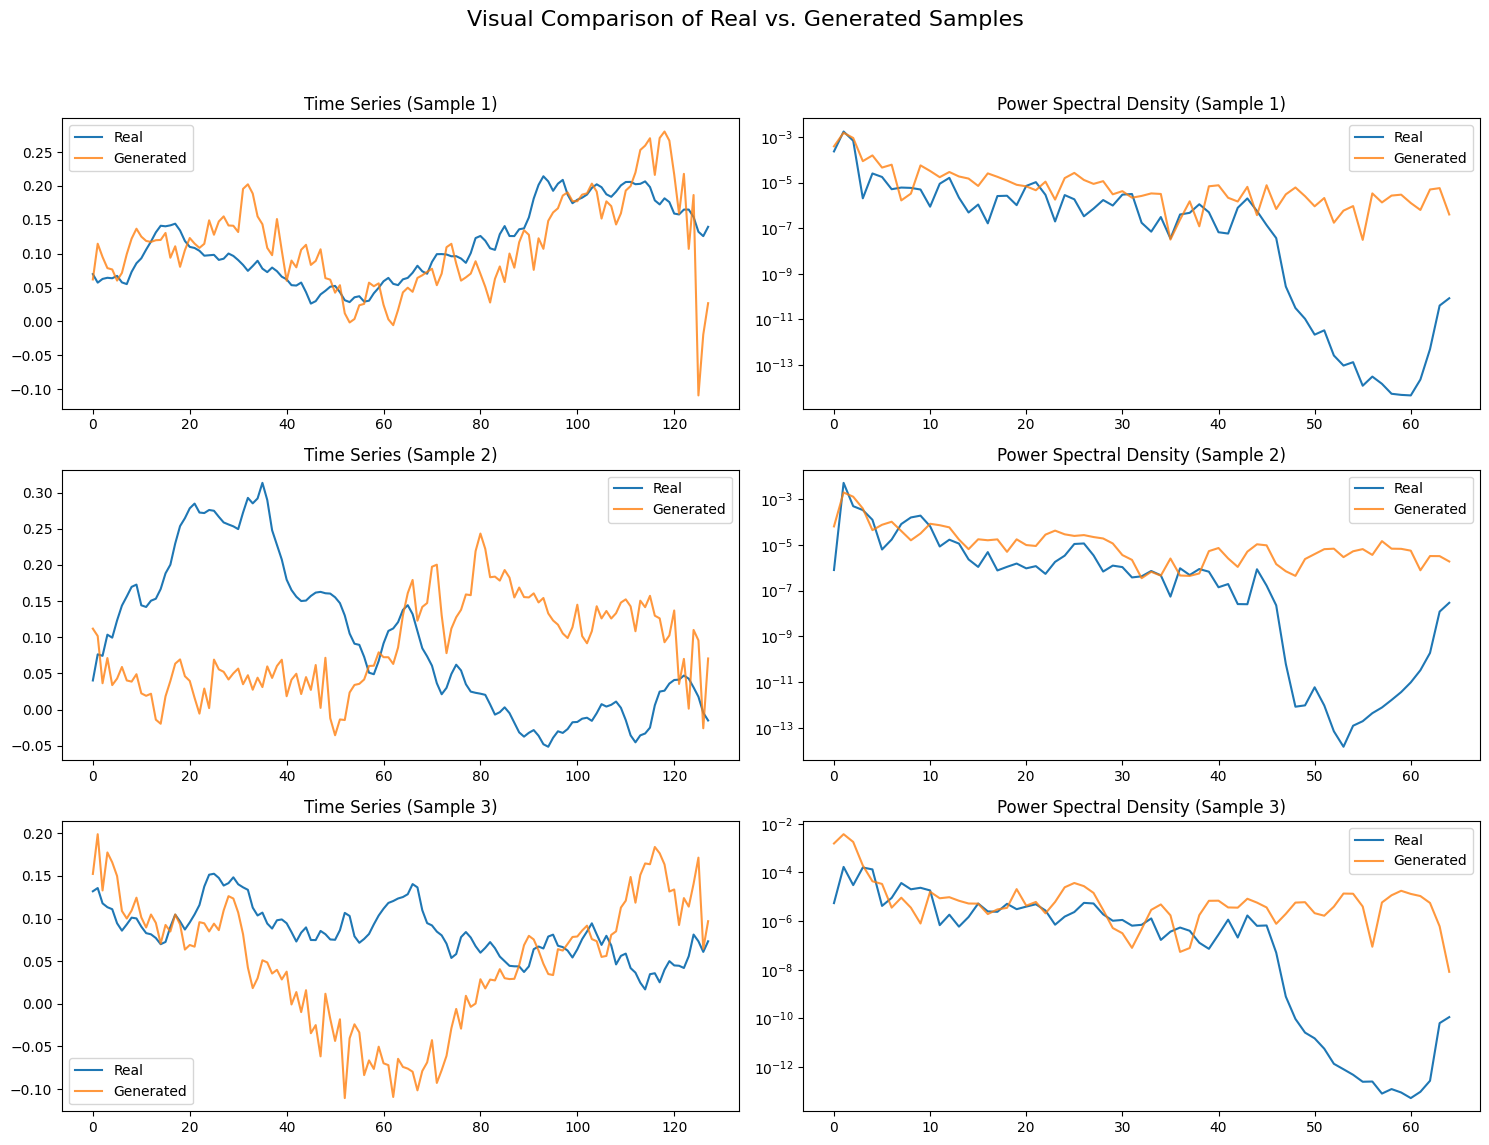


Generating final synthetic dataset for augmentation...
Generating 7519 synthetic samples for class 1...

Augmented dataset saved to /kaggle/working/gan_outputs/augmented_eeg_dataset.npz
Generator model saved to /kaggle/working/gan_outputs/v6_generator.pth
Discriminator model saved to /kaggle/working/gan_outputs/v6_discriminator.pth


In [3]:
# ===================================================================
# CELL 1: cGAN FOR EEG DATA AUGMENTATION (FIXED)
# ===================================================================
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import gc
from scipy import signal
from sklearn.metrics import mean_squared_error
import seaborn as sns
from torch.nn.utils import spectral_norm
import os
import warnings
# --- SETUP ---
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define output directory
GAN_OUTPUT_DIR = "/kaggle/working/gan_outputs"

# --- DATA LOADING & PREPARATION (Unchanged) ---
print("\nLoading and CLEANING dataset for cGAN training...")
try:
    with np.load("/kaggle/input/adftd-alzheimer-eeg-only/adftd_complete.npz") as data:
        X_raw_full = data['X_raw']
        y_labels_str_full = data['y_labels'][:, 0]

    class_0_labels_str = ['0', '0.0']
    class_1_labels_str = ['1', '1.0']
    mask_c0 = np.isin(y_labels_str_full, class_0_labels_str)
    mask_c1 = np.isin(y_labels_str_full, class_1_labels_str)
    valid_mask = mask_c0 | mask_c1

    X_raw_clean = X_raw_full[valid_mask]
    y_labels_filtered = y_labels_str_full[valid_mask]
    
    y_clean = np.zeros(len(y_labels_filtered), dtype=int)
    y_clean[np.isin(y_labels_filtered, class_1_labels_str)] = 1
    
    print(f"Using {len(y_clean)} clean samples for cGAN training.")
    print(f"Class distribution - Class 0: {np.sum(y_clean == 0)}, Class 1: {np.sum(y_clean == 1)}")

except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

print("Normalizing data...")
X_normalized = np.empty_like(X_raw_clean, dtype=np.float32)
for c in range(X_raw_clean.shape[2]):
    min_val = X_raw_clean[:, :, c].min()
    max_val = X_raw_clean[:, :, c].max()
    X_normalized[:, :, c] = 2 * ((X_raw_clean[:, :, c] - min_val) / (max_val - min_val)) - 1

del X_raw_full, X_raw_clean, y_labels_str_full, y_labels_filtered
gc.collect()

X_tensor = torch.from_numpy(X_normalized)
y_tensor = torch.from_numpy(y_clean).type(torch.LongTensor)

batch_size = 64
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(
    dataset, batch_size=batch_size, shuffle=True,
    num_workers=2, pin_memory=True # Reduced num_workers for Kaggle stability
)

del X_normalized, X_tensor
gc.collect()
print("Prepared DataLoader for improved cGAN.")


# --- V6 MODELS (Unchanged) ---
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.BatchNorm1d(in_channels), nn.LeakyReLU(0.2, inplace=True), nn.Upsample(scale_factor=2),
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
        )
        self.shortcut = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_channels, out_channels, kernel_size=1, padding=0)
        )
    def forward(self, x):
        return self.conv_block(x) + self.shortcut(x)

class ResGenerator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=2, channels=19, timesteps=128):
        super(ResGenerator, self).__init__()
        self.timesteps, self.channels = timesteps, channels
        self.label_emb = nn.Embedding(num_classes, latent_dim)
        self.fc = nn.Linear(latent_dim * 2, 256 * (timesteps // 8))
        self.res_blocks = nn.Sequential(
            ResBlock(256, 128), ResBlock(128, 64), ResBlock(64, 32),
        )
        self.final_conv = nn.Sequential(
            nn.BatchNorm1d(32), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(32, channels, kernel_size=3, padding=1), nn.Tanh()
        )
    def forward(self, noise, labels):
        c = self.label_emb(labels)
        x = torch.cat([noise, c], 1)
        x = self.fc(x); x = x.reshape(x.size(0), 256, self.timesteps // 8)
        x = self.res_blocks(x); x = self.final_conv(x)
        return x.transpose(1, 2)

class ImprovedDiscriminator(nn.Module):
    def __init__(self, num_classes=2, timesteps=128, channels=19):
        super(ImprovedDiscriminator, self).__init__()
        self.timesteps, self.channels = timesteps, channels
        self.label_emb = nn.Embedding(num_classes, timesteps * channels)
        self.conv_layers = nn.Sequential(
            spectral_norm(nn.Conv1d(channels, 64, kernel_size=5, stride=2, padding=2)), nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2)), nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv1d(128, 256, kernel_size=5, stride=2, padding=2)), nn.LeakyReLU(0.2, inplace=True),
        )
        self._calculate_conv_output_size()
        self.classifier = nn.Sequential(
            spectral_norm(nn.Linear(self.conv_output_size + (timesteps * channels), 512)), nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Linear(512, 256)), nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Linear(256, 1))
        )
    def _calculate_conv_output_size(self):
        with torch.no_grad():
            self.conv_output_size = self.conv_layers(torch.randn(1, self.channels, self.timesteps)).reshape(1, -1).size(1)
    def forward(self, eeg, labels):
        if self.training:
            eeg = eeg + torch.randn_like(eeg) * 0.05
        x = eeg.transpose(1, 2)
        x = self.conv_layers(x)
        x = x.reshape(x.size(0), -1)
        c = self.label_emb(labels).reshape(labels.size(0), -1)
        return self.classifier(torch.cat([x, c], 1))

# --- HELPER FUNCTIONS (Adjusted Save Paths) ---
def compute_gradient_penalty(discriminator, real_samples, fake_samples, labels, device):
    alpha = torch.rand(real_samples.size(0), 1, 1).to(device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = discriminator(interpolates, labels)
    fake = torch.ones(real_samples.size(0), 1).to(device)
    gradients = torch.autograd.grad(outputs=d_interpolates, inputs=interpolates, grad_outputs=fake, create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.reshape(gradients.size(0), -1)
    return ((gradients.norm(2, dim=1) - 1) ** 2).mean()

def evaluate_sample_quality(real_samples, generated_samples):
    metrics = {}
    sample_size = min(100, len(real_samples), len(generated_samples))
    real_subset = real_samples[np.random.choice(len(real_samples), sample_size, replace=False)]
    gen_subset = generated_samples[np.random.choice(len(generated_samples), sample_size, replace=False)]
    with warnings.catch_warnings(): # Suppress Welch warning for short signals
        warnings.simplefilter("ignore", UserWarning)
        real_psds = [signal.welch(real_subset[i, :, 0], fs=128)[1] for i in range(sample_size)]
        gen_psds = [signal.welch(gen_subset[i, :, 0], fs=128)[1] for i in range(sample_size)]
    metrics['psd_mse'] = mean_squared_error(np.mean(real_psds, axis=0), np.mean(gen_psds, axis=0))
    return metrics

def plot_training_progress(g_losses, d_losses, quality_metrics, save_interval, save_dir):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    axes[0].plot(g_losses, label='Generator Loss'); axes[0].plot(d_losses, label='Discriminator Loss')
    axes[0].set_title('Training Losses'); axes[0].set_xlabel('Epoch'); axes[0].legend(); axes[0].grid(True)
    if quality_metrics:
        epochs = np.arange(1, len(quality_metrics) + 1) * save_interval
        psd_mses = [m['psd_mse'] for m in quality_metrics]
        axes[1].plot(epochs, psd_mses, 'r-o', label='PSD MSE')
        axes[1].set_title('Sample Quality (Lower is Better)'); axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('PSD MSE')
        axes[1].legend(); axes[1].grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'gan_training_progress.png'))
    plt.show()

def compare_real_vs_generated(real_samples, generated_samples, save_dir, num_samples=3):
    fig, axes = plt.subplots(num_samples, 2, figsize=(15, num_samples * 4))
    fig.suptitle('Visual Comparison of Real vs. Generated Samples', fontsize=16)
    for i in range(num_samples):
        real_idx, gen_idx = np.random.randint(0, len(real_samples)), np.random.randint(0, len(generated_samples))
        axes[i, 0].plot(real_samples[real_idx, :, 0], label='Real')
        axes[i, 0].plot(generated_samples[gen_idx, :, 0], label='Generated', alpha=0.8)
        axes[i, 0].set_title(f'Time Series (Sample {i+1})'); axes[i, 0].legend()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            f_real, psd_real = signal.welch(real_samples[real_idx, :, 0], fs=128)
            f_gen, psd_gen = signal.welch(generated_samples[gen_idx, :, 0], fs=128)
        axes[i, 1].semilogy(f_real, psd_real, label='Real')
        axes[i, 1].semilogy(f_gen, psd_gen, label='Generated', alpha=0.8)
        axes[i, 1].set_title(f'Power Spectral Density (Sample {i+1})'); axes[i, 1].legend()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(save_dir, 'gan_real_vs_generated_comparison.png'))
    plt.show()

# --- V6 TRAINING FUNCTION (Unchanged Logic, added discriminator return) ---
def train_v6_gan(dataloader, num_epochs=50, critic_iterations=5, save_interval=20):
    generator = ResGenerator().to(device)
    discriminator = ImprovedDiscriminator().to(device)
    lr_g, lr_d, diversity_weight = 1e-4, 1e-4, 0.1
    g_optimizer = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
    g_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(g_optimizer, 'min', factor=0.5, patience=15)
    d_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(d_optimizer, 'min', factor=0.5, patience=15)
    g_losses, d_losses, quality_metrics = [], [], []
    lambda_gp_initial, lambda_gp_final, anneal_epochs = 0.1, 10, 50
    
    # FIX: Corrected print statement
    print("\nStarting V6 cWGAN-GP training with ResNet generator...")
    for epoch in range(num_epochs):
        lambda_gp = lambda_gp_final if epoch >= anneal_epochs else lambda_gp_initial + (lambda_gp_final - lambda_gp_initial) * (epoch / anneal_epochs)
        epoch_g_losses, epoch_d_losses = [], []
        
        for i, (real_eegs, labels) in enumerate(dataloader):
            real_eegs, labels = real_eegs.to(device), labels.to(device)
            d_optimizer.zero_grad()
            z = torch.randn(real_eegs.size(0), 100).to(device)
            fake_eegs = generator(z, labels).detach()
            real_validity = discriminator(real_eegs, labels)
            fake_validity = discriminator(fake_eegs, labels)
            gradient_penalty = compute_gradient_penalty(discriminator, real_eegs.data, fake_eegs.data, labels.data, device)
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty
            d_loss.backward(); d_optimizer.step(); epoch_d_losses.append(d_loss.item())
            
            if i % critic_iterations == 0:
                g_optimizer.zero_grad()
                z1 = torch.randn(real_eegs.size(0), 100).to(device)
                gen_labels = torch.randint(0, 2, (real_eegs.size(0),)).to(device)
                fake_eegs1 = generator(z1, gen_labels)
                g_loss_adv = -torch.mean(discriminator(fake_eegs1, gen_labels))
                z2 = torch.randn(real_eegs.size(0), 100).to(device)
                fake_eegs2 = generator(z2, gen_labels)
                lz = torch.mean(torch.abs(z2 - z1)); lf = torch.mean(torch.abs(fake_eegs2 - fake_eegs1))
                g_loss_div = diversity_weight * (lz / (lf + 1e-8))
                g_loss = g_loss_adv + g_loss_div
                g_loss.backward(); g_optimizer.step(); epoch_g_losses.append(g_loss.item())
                
        avg_g_loss = np.mean(epoch_g_losses) if epoch_g_losses else 0
        avg_d_loss = np.mean(epoch_d_losses)
        g_losses.append(avg_g_loss); d_losses.append(avg_d_loss)
        g_scheduler.step(avg_g_loss); d_scheduler.step(avg_d_loss)
        
        if (epoch + 1) % save_interval == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], D Loss: {avg_d_loss:.4f}, G Loss: {avg_g_loss:.4f}, Lambda GP: {lambda_gp:.2f}")
            with torch.no_grad():
                generator.eval()
                generated_samples = generator(torch.randn(500, 100).to(device), torch.randint(0, 2, (500,)).to(device)).cpu().numpy()
                metrics = evaluate_sample_quality(dataloader.dataset.tensors[0][:500].numpy(), generated_samples)
                quality_metrics.append(metrics)
                print(f"  Quality - PSD MSE: {metrics['psd_mse']:.8f}")
                generator.train()

    # FIX: Return discriminator as well
    return generator, discriminator, g_losses, d_losses, quality_metrics

# --- EXECUTION AND SAVING ---
# Train the model (reduced epochs for faster Kaggle execution, you can increase it)
SAVE_INTERVAL_FOR_LOGS = 1

trained_generator, trained_discriminator, g_losses, d_losses, quality_metrics = train_v6_gan(
    dataloader, 
    num_epochs=5, 
    save_interval=SAVE_INTERVAL_FOR_LOGS
)
# Plot training progress
plot_training_progress(g_losses, d_losses, quality_metrics, save_interval=25, save_dir=GAN_OUTPUT_DIR)

# Visualize a comparison
print("\nVisual comparison of Real vs. Generated Samples:")
trained_generator.eval()
with torch.no_grad():
    vis_generated = trained_generator(torch.randn(10, 100).to(device), torch.randint(0, 2, (10,)).to(device)).cpu().numpy()
compare_real_vs_generated(dataloader.dataset.tensors[0][:10].numpy(), vis_generated, save_dir=GAN_OUTPUT_DIR)

# Generate final synthetic dataset
print("\nGenerating final synthetic dataset for augmentation...")
y_clean_final = dataloader.dataset.tensors[1].numpy()
class_counts = np.bincount(y_clean_final)
max_count = np.max(class_counts)
samples_to_generate = max_count - class_counts
synthetic_samples_list, synthetic_labels_list = [], []

for class_label, num_to_gen in enumerate(samples_to_generate):
    if num_to_gen > 0:
        print(f"Generating {num_to_gen} synthetic samples for class {class_label}...")
        with torch.no_grad():
            trained_generator.eval()
            generated_data_parts = []
            gen_batch_size = 512
            for i in range(0, num_to_gen, gen_batch_size):
                current_batch_size = min(gen_batch_size, num_to_gen - i)
                z_gen = torch.randn(current_batch_size, 100).to(device)
                labels_gen = torch.LongTensor([class_label] * current_batch_size).to(device)
                generated_data_parts.append(trained_generator(z_gen, labels_gen).cpu().numpy())
            synthetic_samples_list.append(np.concatenate(generated_data_parts, axis=0))
            generated_labels = np.zeros((num_to_gen, 3), dtype=object)
            generated_labels[:, 0] = str(class_label); generated_labels[:, 1] = -1; generated_labels[:, 2] = "synthetic"
            synthetic_labels_list.append(generated_labels)

# Save the final augmented dataset file
if synthetic_samples_list:
    X_synthetic = np.concatenate(synthetic_samples_list, axis=0)
    y_synthetic = np.concatenate(synthetic_labels_list, axis=0)
    with np.load("/kaggle/input/adftd-alzheimer-eeg-only/adftd_complete.npz") as data:
        X_original, y_original = data['X_raw'], data['y_labels']
    save_path = os.path.join(GAN_OUTPUT_DIR, "augmented_eeg_dataset.npz")
    np.savez_compressed(save_path, X_original=X_original, y_original=y_original, X_synthetic=X_synthetic, y_synthetic=y_synthetic)
    print(f"\nAugmented dataset saved to {save_path}")

# --- PROPERLY SAVE THE TRAINED MODELS ---
generator_save_path = os.path.join(GAN_OUTPUT_DIR, "v6_generator.pth")
discriminator_save_path = os.path.join(GAN_OUTPUT_DIR, "v6_discriminator.pth")
torch.save(trained_generator.state_dict(), generator_save_path)
torch.save(trained_discriminator.state_dict(), discriminator_save_path)
print(f"Generator model saved to {generator_save_path}")
print(f"Discriminator model saved to {discriminator_save_path}")

Using device: cuda

STEP 1: PROCESSING AUGMENTED DATASET
Extracting handcrafted features for 48196 samples...
Normalizing raw EEG signals (instance-wise)...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv2d(



Training EEGNetFusion model on augmented data...
Epoch 5/30, Val Acc: 0.8743
Epoch 10/30, Val Acc: 0.9141
Epoch 15/30, Val Acc: 0.9216
Epoch 20/30, Val Acc: 0.9152
Epoch 25/30, Val Acc: 0.9372
Epoch 30/30, Val Acc: 0.9445
Training finished. Best validation accuracy: 0.9455 saved to /kaggle/working/classifier_outputs/model_augmented.pth

STEP 2: FINAL EVALUATION
--- Full Evaluation on Augmented Model on Augmented Test Set ---
(Using Test Time Augmentation)
                       precision    recall  f1-score   support

    Class 0 (Control)       0.95      0.94      0.95      4820
Class 1 (Alzheimer's)       0.94      0.95      0.95      4820

             accuracy                           0.95      9640
            macro avg       0.95      0.95      0.95      9640
         weighted avg       0.95      0.95      0.95      9640



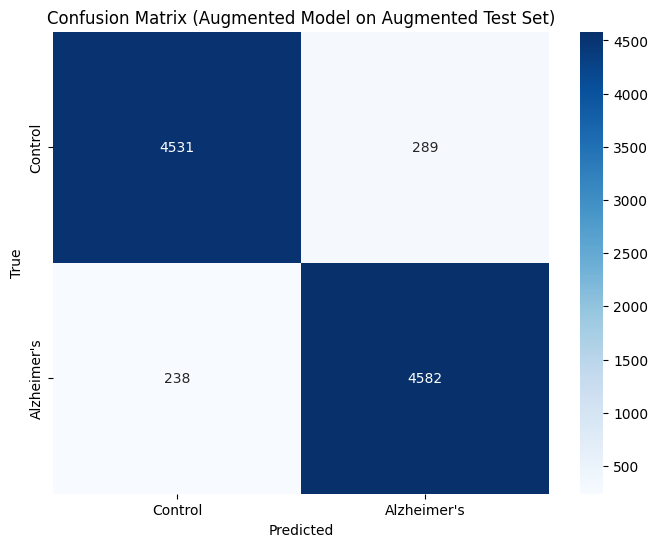

In [4]:
# ===================================================================
# CELL 2: EEG CLASSIFICATION (FIXED)
# ===================================================================
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch
from scipy.integrate import simpson as simps
import gc
import os

# --- SETUP ---
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define directories
CLASSIFIER_OUTPUT_DIR = "/kaggle/working/classifier_outputs"
GAN_OUTPUT_DIR = "/kaggle/working/gan_outputs"

# --- MODEL DEFINITION (Unchanged) ---
class EEGNetFusion(nn.Module):
    def __init__(self, num_channels=19, num_timesteps=128, num_features=266, num_classes=2, F1=16, D=2, F2=32):
        super(EEGNetFusion, self).__init__()
        self.eegnet_branch = nn.Sequential(
            nn.Conv2d(1, F1, kernel_size=(1, 64), padding='same', bias=False), nn.BatchNorm2d(F1),
            nn.Conv2d(F1, F1 * D, kernel_size=(num_channels, 1), groups=F1, bias=False), nn.BatchNorm2d(F1 * D), nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 4)), nn.Dropout(p=0.5),
            nn.Conv2d(F1 * D, F2, kernel_size=(1, 16), padding='same', groups=F1*D, bias=False),
            nn.Conv2d(F2, F2, kernel_size=(1, 1), bias=False), nn.BatchNorm2d(F2), nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8)), nn.Dropout(p=0.5), nn.Flatten()
        )
        self.feature_branch = nn.Sequential(
            nn.Linear(num_features, 128), nn.BatchNorm1d(128), nn.ELU(), nn.Dropout(p=0.6),
            nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ELU()
        )
        with torch.no_grad():
            self.eegnet_out_size = self.eegnet_branch(torch.randn(1, 1, num_channels, num_timesteps)).shape[1]
        self.classifier = nn.Sequential(
            nn.Linear(self.eegnet_out_size + 64, 128), nn.ELU(), nn.Dropout(p=0.6),
            nn.Linear(128, num_classes)
        )
    def forward(self, raw_eeg, features):
        raw_eeg_input = raw_eeg.permute(0, 2, 1).unsqueeze(1)
        eegnet_output = self.eegnet_branch(raw_eeg_input)
        feature_output = self.feature_branch(features)
        fused_output = torch.cat((eegnet_output, feature_output), dim=1)
        return self.classifier(fused_output)

# --- DATA PROCESSING & TRAINING FUNCTIONS ---
def extract_enhanced_features(X_batch, sfreq=128):
    bands = {'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 30), 'gamma': (30, 50)}
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        psd_list = [welch(sample, fs=sfreq, nperseg=X_batch.shape[1], axis=0)[1] for sample in X_batch]
        freqs = welch(X_batch[0], fs=sfreq, nperseg=X_batch.shape[1], axis=0)[0]
    psd_array = np.transpose(np.array(psd_list), (0, 2, 1))
    all_band_powers, freq_res = [], freqs[1] - freqs[0]
    for band_limits in bands.values():
        idx = np.logical_and(freqs >= band_limits[0], freqs <= band_limits[1])
        all_band_powers.append(simps(psd_array[:, :, idx], dx=freq_res, axis=-1))
    abs_bp = np.stack(all_band_powers, axis=-1)
    rel_bp = abs_bp / (abs_bp.sum(axis=-1, keepdims=True) + 1e-10)
    return np.concatenate([
        rel_bp.reshape(X_batch.shape[0], -1), abs_bp.reshape(X_batch.shape[0], -1),
        X_batch.mean(axis=1), X_batch.std(axis=1), X_batch.max(axis=1), X_batch.min(axis=1)
    ], axis=1).astype(np.float32)

def extract_features_in_batches(X_raw, batch_size=512):
    n_samples = X_raw.shape[0]; all_features = []
    print(f"Extracting handcrafted features for {n_samples} samples...")
    for i in range(0, n_samples, batch_size):
        all_features.append(extract_enhanced_features(X_raw[i:min(i + batch_size, n_samples)]))
    return np.concatenate(all_features, axis=0)

def process_and_prepare_dataset(X_raw, y_labels):
    X_features = extract_features_in_batches(X_raw)
    print("Normalizing raw EEG signals (instance-wise)...")
    X_raw_normalized = np.empty_like(X_raw, dtype=np.float32)
    for i in range(X_raw.shape[0]):
        mean, std = X_raw[i].mean(axis=0, keepdims=True), X_raw[i].std(axis=0, keepdims=True)
        X_raw_normalized[i] = (X_raw[i] - mean) / (std + 1e-8)
    return torch.FloatTensor(X_raw_normalized), torch.FloatTensor(X_features), torch.LongTensor(y_labels)

def train_model(model, train_loader, test_loader, num_epochs, model_save_path):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.2, patience=5)
    best_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        for raw_eeg, features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(raw_eeg.to(device), features.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward(); optimizer.step()
        val_acc = evaluate_accuracy(model, test_loader)
        scheduler.step(val_acc)
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), model_save_path)
        if (epoch + 1) % 5 == 0: print(f"Epoch {epoch+1}/{num_epochs}, Val Acc: {val_acc:.4f}")
    print(f"Training finished. Best validation accuracy: {best_acc:.4f} saved to {model_save_path}")
    model.load_state_dict(torch.load(model_save_path))
    return model

def evaluate_accuracy(model, loader):
    model.eval(); correct, total = 0, 0
    with torch.no_grad():
        for raw_eeg, features, labels in loader:
            outputs = model(raw_eeg.to(device), features.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0); correct += (predicted == labels.to(device)).sum().item()
    return correct / total

def full_evaluation(model, loader, dataset_name, save_dir, use_tta=True, tta_iterations=5):
    model.eval(); all_preds, all_labels = [], []
    with torch.no_grad():
        for raw_eeg, features, labels in loader:
            raw_eeg, features, labels = raw_eeg.to(device), features.to(device), labels.to(device)
            if use_tta:
                tta_outputs = [model(raw_eeg + (torch.randn_like(raw_eeg) * 0.01), features).softmax(dim=1) for _ in range(tta_iterations)]
                _, preds = torch.max(torch.mean(torch.stack(tta_outputs), dim=0), 1)
            else:
                _, preds = torch.max(model(raw_eeg, features), 1)
            all_preds.extend(preds.cpu().numpy()); all_labels.extend(labels.cpu().numpy())
            
    report_text = f"--- Full Evaluation on {dataset_name} ---\n"
    if use_tta: report_text += "(Using Test Time Augmentation)\n"
    report = classification_report(all_labels, all_preds, target_names=['Class 0 (Control)', "Class 1 (Alzheimer's)"])
    report_text += report
    print(report_text)
    
    # Save the report and confusion matrix
    with open(os.path.join(save_dir, f"classification_report_{dataset_name.replace(' ', '_')}.txt"), "w") as f:
        f.write(report_text)
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Control', "Alzheimer's"], yticklabels=['Control', "Alzheimer's"])
    plt.title(f'Confusion Matrix ({dataset_name})'); plt.xlabel('Predicted'); plt.ylabel('True')
    plt.savefig(os.path.join(save_dir, f"confusion_matrix_{dataset_name.replace(' ', '_')}.png"))
    plt.show()

# --- MAIN EXECUTION PIPELINE ---
if __name__ == "__main__":
    original_dataset_path = "/kaggle/input/adftd-alzheimer-eeg-only/adftd_complete.npz"
    augmented_dataset_path = os.path.join(GAN_OUTPUT_DIR, "augmented_eeg_dataset.npz")

    # --- Step 1: Prepare and Train on Augmented Data (Primary Path) ---
    print("\n" + "="*50 + "\nSTEP 1: PROCESSING AUGMENTED DATASET\n" + "="*50)
    with np.load(augmented_dataset_path, allow_pickle=True) as data:
        X_aug_raw = np.concatenate((data['X_original'], data['X_synthetic']), axis=0)
        y_aug_str = np.concatenate((data['y_original'][:, 0], data['y_synthetic'][:, 0]), axis=0)
    
    valid_mask_aug = np.isin(y_aug_str, ['0', '0.0', '1', '1.0'])
    X_aug_clean, y_aug_str_clean = X_aug_raw[valid_mask_aug], y_aug_str[valid_mask_aug]
    y_aug_clean = np.isin(y_aug_str_clean, ['1', '1.0']).astype(int)
    
    X_aug_raw_t, X_aug_feat_t, y_aug_t = process_and_prepare_dataset(X_aug_clean, y_aug_clean)
    aug_dataset = TensorDataset(X_aug_raw_t, X_aug_feat_t, y_aug_t)
    
    train_idx_aug, test_idx_aug = train_test_split(range(len(aug_dataset)), test_size=0.2, random_state=42, stratify=y_aug_t)
    aug_train_loader = DataLoader(Subset(aug_dataset, train_idx_aug), batch_size=64, shuffle=True)
    aug_test_loader = DataLoader(Subset(aug_dataset, test_idx_aug), batch_size=64, shuffle=False)
    
    model_aug = EEGNetFusion()
    model_aug_path = os.path.join(CLASSIFIER_OUTPUT_DIR, 'model_augmented.pth')
    print("\nTraining EEGNetFusion model on augmented data...")
    model_aug = train_model(model_aug, aug_train_loader, aug_test_loader, num_epochs=30, model_save_path=model_aug_path)

    # --- Step 2: Final Evaluation ---
    print("\n" + "="*50 + "\nSTEP 2: FINAL EVALUATION\n" + "="*50)
    full_evaluation(model_aug, aug_test_loader, "Augmented Model on Augmented Test Set", CLASSIFIER_OUTPUT_DIR)

--- Initializing Cell 3: Unified XAI Analysis ---

==================== PART 1: CLASSIFIER XAI ====================

--- Loading Classifier Model and Data ---
Classifier loaded successfully from /kaggle/working/classifier_outputs/model_augmented.pth
Extracting handcrafted features for 48196 samples...

--- Running SHAP Explainer on Handcrafted Features ---

--- Running SHAP Explainer on Handcrafted Features (with batched wrapper) ---


  0%|          | 0/20 [00:00<?, ?it/s]

SHAP values calculated successfully.
Generating Global Feature Importance Plot...


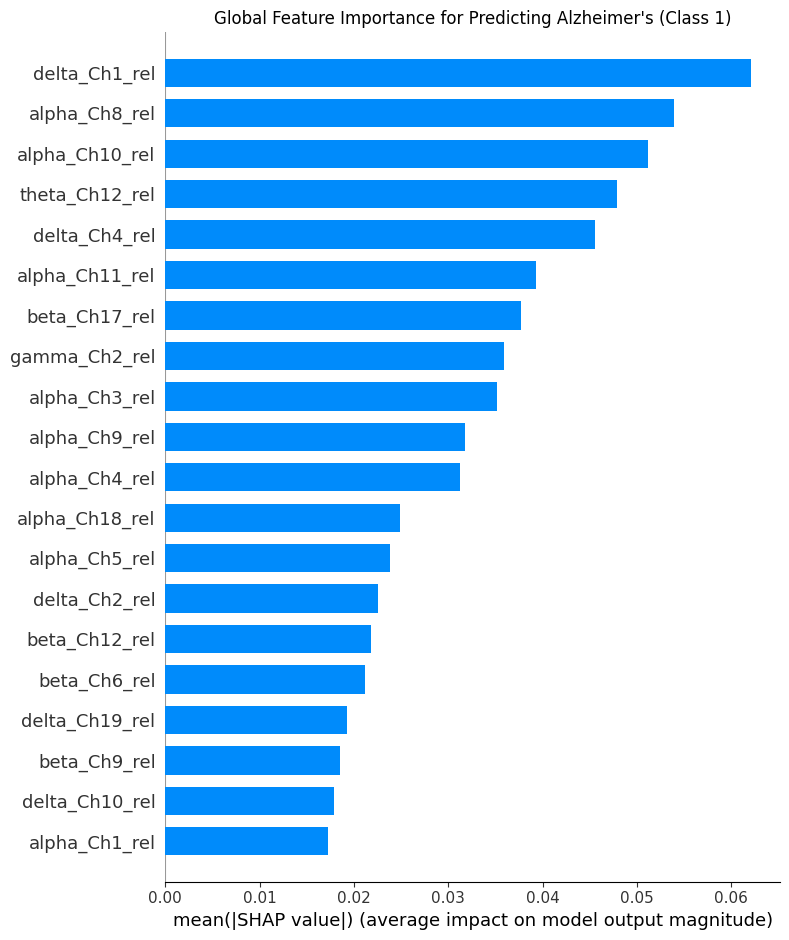

Generating Local Explanation (Waterfall Plot)...


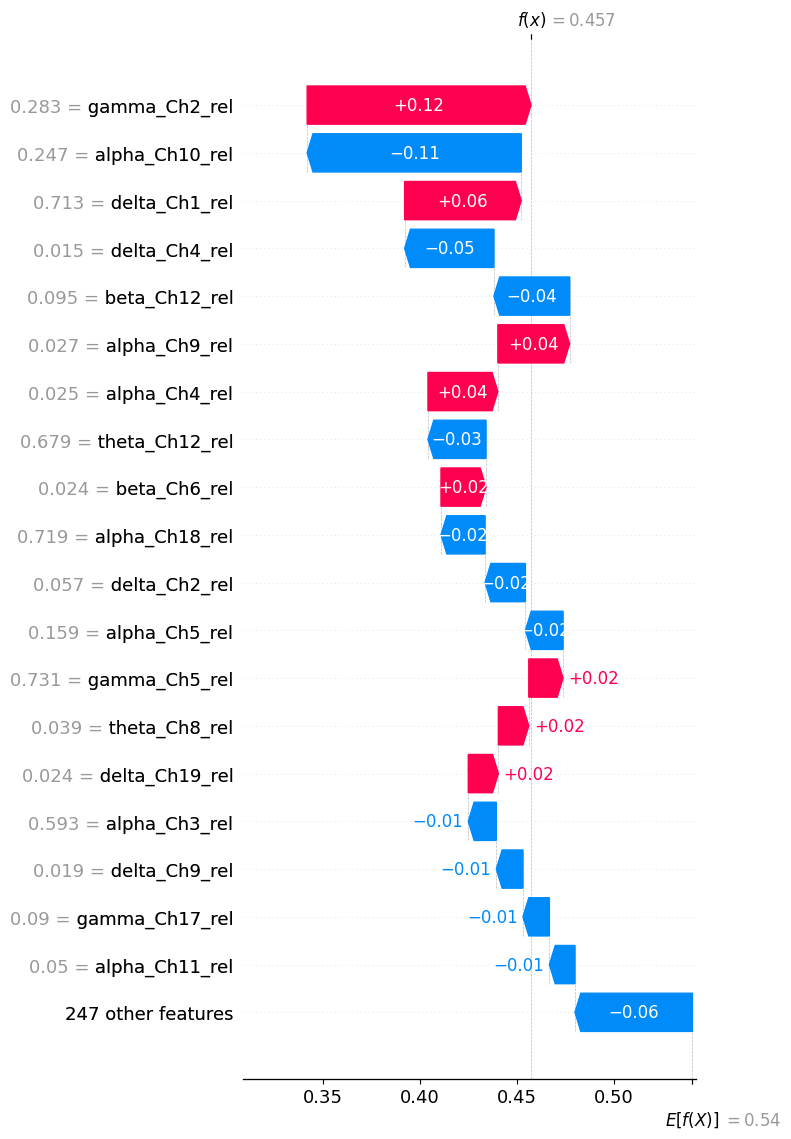

In [5]:
# ===================================================================
# CELL 3: EXPLAINABLE AI FOR CLASSIFIER AND GENERATOR (FIXED)
# ===================================================================
import numpy as np
import torch
import torch.nn as nn
import shap
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import train_test_split
import gc
from scipy.signal import welch
from scipy.integrate import simpson as simps
import os
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
print("--- Initializing Cell 3: Unified XAI Analysis ---")

# --- SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
XAI_OUTPUT_DIR = "/kaggle/working/xai_outputs"
CLASSIFIER_OUTPUT_DIR = "/kaggle/working/classifier_outputs"
GAN_OUTPUT_DIR = "/kaggle/working/gan_outputs"

# ===================================================================
# PART 1: EXPLAINING THE CLASSIFIER (EEGNetFusion)
# ===================================================================
print("\n" + "="*20 + " PART 1: CLASSIFIER XAI " + "="*20)

# --- STEP 1.1: DEFINE NECESSARY CLASSES AND FUNCTIONS ---
# Re-defining here to keep cell independent
class EEGNetFusion(nn.Module):
    def __init__(self, num_channels=19, num_timesteps=128, num_features=266, num_classes=2, F1=16, D=2, F2=32):
        super(EEGNetFusion, self).__init__()
        self.eegnet_branch = nn.Sequential(
            nn.Conv2d(1, F1, kernel_size=(1, 64), padding='same', bias=False), nn.BatchNorm2d(F1),
            nn.Conv2d(F1, F1 * D, kernel_size=(num_channels, 1), groups=F1, bias=False), nn.BatchNorm2d(F1 * D), nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 4)), nn.Dropout(p=0.5),
            nn.Conv2d(F1 * D, F2, kernel_size=(1, 16), padding='same', groups=F1*D, bias=False),
            nn.Conv2d(F2, F2, kernel_size=(1, 1), bias=False), nn.BatchNorm2d(F2), nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8)), nn.Dropout(p=0.5), nn.Flatten()
        )
        self.feature_branch = nn.Sequential(
            nn.Linear(num_features, 128), nn.BatchNorm1d(128), nn.ELU(), nn.Dropout(p=0.6),
            nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ELU()
        )
        with torch.no_grad():
            self.eegnet_out_size = self.eegnet_branch(torch.randn(1, 1, num_channels, num_timesteps)).shape[1]
        self.classifier = nn.Sequential(
            nn.Linear(self.eegnet_out_size + 64, 128), nn.ELU(), nn.Dropout(p=0.6),
            nn.Linear(128, num_classes)
        )
    def forward(self, raw_eeg, features):
        eegnet_output = self.eegnet_branch(raw_eeg.permute(0, 2, 1).unsqueeze(1))
        feature_output = self.feature_branch(features)
        return self.classifier(torch.cat((eegnet_output, feature_output), dim=1))

# --- STEP 1.2: LOAD MODEL AND PREPARE DATA ---
print("\n--- Loading Classifier Model and Data ---")
model_classifier = EEGNetFusion()
model_path = os.path.join(CLASSIFIER_OUTPUT_DIR, 'model_augmented.pth')
model_classifier.load_state_dict(torch.load(model_path, map_location=device))
model_classifier.to(device); model_classifier.eval()
print(f"Classifier loaded successfully from {model_path}")

# Load a small subset of test data for explanation
with np.load(os.path.join(GAN_OUTPUT_DIR, "augmented_eeg_dataset.npz"), allow_pickle=True) as data:
    X_aug_raw = np.concatenate((data['X_original'], data['X_synthetic']), axis=0)
    y_aug_str = np.concatenate((data['y_original'][:, 0], data['y_synthetic'][:, 0]), axis=0)
valid_mask = np.isin(y_aug_str, ['0', '0.0', '1', '1.0'])
X_clean, y_str_clean = X_aug_raw[valid_mask], y_aug_str[valid_mask]
y_clean = np.isin(y_str_clean, ['1', '1.0']).astype(int)

# Re-use feature extraction from Cell 2
X_features = extract_features_in_batches(X_clean)
X_raw_norm = np.empty_like(X_clean, dtype=np.float32)
for i in range(len(X_clean)):
    mean, std = X_clean[i].mean(axis=0, keepdims=True), X_clean[i].std(axis=0, keepdims=True)
    X_raw_norm[i] = (X_clean[i] - mean) / (std + 1e-8)

_, test_indices = train_test_split(range(len(y_clean)), test_size=0.2, random_state=42, stratify=y_clean)
background_indices = np.random.choice(test_indices, 100, replace=False)
explain_indices = np.random.choice(test_indices, 20, replace=False)

background_raw = torch.from_numpy(X_raw_norm[background_indices]).to(device)
background_feat = torch.from_numpy(X_features[background_indices]).to(device)
explain_feat = torch.from_numpy(X_features[explain_indices])

# --- STEP 1.3: RUN SHAP ON HANDCRAFTED FEATURES (More Interpretable & Efficient) ---
print("\n--- Running SHAP Explainer on Handcrafted Features ---")
# SHAP works best on model inputs. We create a wrapper that takes only features.
# To do this, we need a "background" for the raw_eeg part. We'll use the mean.
mean_background_raw = background_raw.mean(dim=0, keepdim=True)

# ===================================================================
# CELL 3: XAI (CODE TO REPLACE)
# ===================================================================

# FIX: Replace the SHAP wrapper with a memory-efficient, batched version.
# This prevents the OOM error by processing SHAP's large synthetic dataset in smaller chunks.

def feature_prediction_wrapper_batched(features_numpy, batch_size=32):
    """
    A memory-efficient wrapper for SHAP that processes predictions in batches.
    """
    num_total_samples = features_numpy.shape[0]
    all_probabilities = []
    
    # Process the large input array in smaller batches
    for i in range(0, num_total_samples, batch_size):
        # Get the current batch of handcrafted features
        current_batch_features_numpy = features_numpy[i:i + batch_size]
        current_batch_size = current_batch_features_numpy.shape[0]
        
        # Convert to tensor
        features_tensor = torch.from_numpy(current_batch_features_numpy).float().to(device)
        
        # Repeat the mean raw background for only the current, smaller batch
        raw_input = mean_background_raw.repeat(current_batch_size, 1, 1)
        
        with torch.no_grad():
            # Get model predictions for the small batch
            logits = model_classifier(raw_input, features_tensor)
            probabilities = torch.softmax(logits, dim=1).cpu().numpy()
            all_probabilities.append(probabilities)

    # Concatenate the results from all batches
    return np.concatenate(all_probabilities, axis=0)

print("\n--- Running SHAP Explainer on Handcrafted Features (with batched wrapper) ---")
# SHAP works best on model inputs. We use our new batched wrapper.
# The mean raw_eeg part is handled inside the wrapper now.
mean_background_raw = background_raw.mean(dim=0, keepdim=True)

# Call the new wrapper function
explainer = shap.KernelExplainer(feature_prediction_wrapper_batched, background_feat.cpu().numpy())
shap_values = explainer.shap_values(explain_feat.numpy())
print("SHAP values calculated successfully.")

# The rest of the cell remains the same...

# --- STEP 1.4: VISUALIZE SHAP RESULTS ---
band_names = ['delta', 'theta', 'alpha', 'beta', 'gamma']
channel_names = [f'Ch{i+1}' for i in range(19)]
stat_names = ['mean', 'std', 'max', 'min']
feature_names = ([f'{b}_{ch}_rel' for b in band_names for ch in channel_names] +
                 [f'{b}_{ch}_abs' for b in band_names for ch in channel_names] +
                 [f'{s}_{ch}' for s in stat_names for ch in channel_names])
df_handcrafted = pd.DataFrame(explain_feat.numpy(), columns=feature_names)

print("Generating Global Feature Importance Plot...")
plt.figure()
shap.summary_plot(shap_values[1], df_handcrafted, plot_type="bar", show=False, max_display=20)
plt.title("Global Feature Importance for Predicting Alzheimer's (Class 1)")
plt.tight_layout(); plt.savefig(os.path.join(XAI_OUTPUT_DIR, "classifier_shap_global_importance.png")); plt.show()

print("Generating Local Explanation (Waterfall Plot)...")
plt.figure()
shap.plots.waterfall(shap.Explanation(
    values=shap_values[1][0], base_values=explainer.expected_value[1],
    data=df_handcrafted.iloc[0], feature_names=feature_names
), max_display=20, show=False)
plt.tight_layout(); plt.savefig(os.path.join(XAI_OUTPUT_DIR, "classifier_shap_waterfall_plot.png")); plt.show()





==================== PART 2: GENERATOR XAI ====================

Generator loaded successfully from /kaggle/working/gan_outputs/v6_generator.pth

--- Analyzing Latent Space (Interpolation) ---


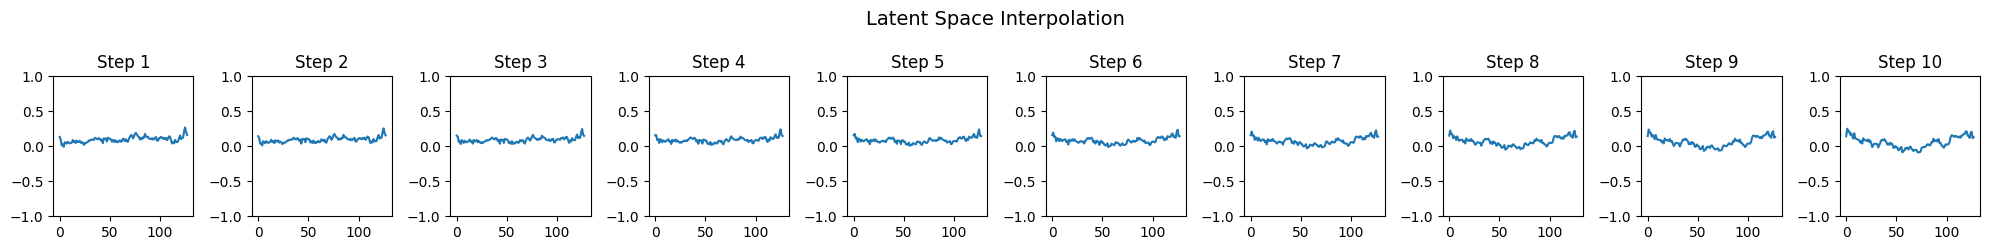


--- XAI Analysis Complete ---


In [6]:
# ===================================================================
# PART 2: EXPLAINING THE GENERATOR (GAN)
# ===================================================================
print("\n" + "="*20 + " PART 2: GENERATOR XAI " + "="*20)

# --- STEP 2.1: DEFINE & LOAD GENERATOR ---

# FIX: Use the EXACT same model definitions as in Cell 1 to ensure a perfect match.
# This is the original, correct ResBlock definition from Cell 1.
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.BatchNorm1d(in_channels), nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
        )
        self.shortcut = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_channels, out_channels, kernel_size=1, padding=0)
        )
    def forward(self, x):
        return self.conv_block(x) + self.shortcut(x)

# This is the original, correct ResGenerator definition from Cell 1.
class ResGenerator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=2, channels=19, timesteps=128):
        super(ResGenerator, self).__init__()
        self.timesteps, self.channels = timesteps, channels
        self.label_emb = nn.Embedding(num_classes, latent_dim)
        self.fc = nn.Linear(latent_dim * 2, 256 * (timesteps // 8))
        self.res_blocks = nn.Sequential(
            ResBlock(256, 128), ResBlock(128, 64), ResBlock(64, 32),
        )
        self.final_conv = nn.Sequential(
            nn.BatchNorm1d(32), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(32, channels, kernel_size=3, padding=1),
            nn.Tanh()
        )
    def forward(self, noise, labels):
        c = self.label_emb(labels)
        x = torch.cat([noise, c], 1)
        x = self.fc(x)
        x = x.reshape(x.size(0), 256, self.timesteps // 8)
        x = self.res_blocks(x)
        x = self.final_conv(x)
        return x.transpose(1, 2)

model_generator = ResGenerator().to(device)
generator_path = os.path.join(GAN_OUTPUT_DIR, "v6_generator.pth")
model_generator.load_state_dict(torch.load(generator_path, map_location=device))
model_generator.eval()
print(f"\nGenerator loaded successfully from {generator_path}")

# --- STEP 2.2: LATENT SPACE ANALYSIS ---
def analyze_latent_space(generator, device, save_dir, n_steps=10):
    z1, z2 = torch.randn(1, 100).to(device), torch.randn(1, 100).to(device)
    label = torch.LongTensor([1]).to(device); seq = []
    with torch.no_grad():
        for alpha in np.linspace(0, 1, n_steps):
            seq.append(generator((1 - alpha) * z1 + alpha * z2, label).cpu().numpy().squeeze())
    fig, axes = plt.subplots(1, n_steps, figsize=(n_steps * 2, 2.5))
    fig.suptitle("Latent Space Interpolation", fontsize=14)
    for i, eeg in enumerate(seq):
        axes[i].plot(eeg[:, 0]); axes[i].set_title(f"Step {i+1}"); axes[i].set_ylim(-1, 1)
    plt.tight_layout(); plt.savefig(os.path.join(save_dir, "gan_latent_space_interpolation.png")); plt.show()

print("\n--- Analyzing Latent Space (Interpolation) ---")
analyze_latent_space(model_generator, device, XAI_OUTPUT_DIR)

print("\n--- XAI Analysis Complete ---")
del model_classifier, model_generator, explainer, shap_values
gc.collect()
torch.cuda.empty_cache()

In [7]:
# # ===================================================================
# # CELL 4: INSTALLATION ONLY
# # ===================================================================

# # This cell's only purpose is to install the correct, pinned versions
# # of our required libraries.

# !pip install -q -U "transformers==4.40.0" "bitsandbytes==0.43.0" "peft==0.10.0" "accelerate==0.29.3" "datasets"

# # IMPORTANT: This command will automatically restart the Kaggle kernel.
# # The output will say "Your session crashed for an unknown reason." This is EXPECTED.
# # After the restart, DO NOT RUN THIS CELL AGAIN. Proceed to the next cell (Cell 5).
# import os
# os.kill(os.getpid(), 9)

In [8]:
# ===================================================================
# CELL 4: LLM FINE-TUNING WITH STANDARD LoRA (DEFINITIVE FIX)
# ===================================================================
# This cell implements our final strategy:
# 1. It abandons the problematic 'bitsandbytes' library and 4-bit quantization.
# 2. It uses standard LoRA fine-tuning in 16-bit precision (FP16).
# This avoids the CUDA setup errors entirely.

# Step 1: Install the necessary libraries (NO bitsandbytes)
!pip install -q -U "transformers==4.40.0" "peft==0.10.0" "accelerate==0.29.3" "datasets"

# Step 2: Import all required packages
import numpy as np
import torch
import pandas as pd
import os
import gc
from datasets import Dataset
import transformers
from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import warnings

warnings.filterwarnings("ignore")
print(f"Transformers version: {transformers.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Define Directories ---
LLM_OUTPUT_DIR = "/kaggle/working/llm_outputs"
os.makedirs(LLM_OUTPUT_DIR, exist_ok=True)


# --- Step 3: Generate the Fine-Tuning Corpus (Unchanged) ---
def generate_textual_explanation(top_features_df, base_prob, final_prob, true_label_str, patient_id):
    pred_label_str = "Alzheimer's" if final_prob > 0.5 else "Healthy"
    text = f"**Clinical EEG Report for Patient ID {patient_id}**\n\n- **Final Prediction:** {pred_label_str} (Model Confidence: {final_prob:.1%})\n- **Ground Truth:** {true_label_str}\n\n**Analysis Summary:**\nThe model's base assumption predicted a {base_prob:.1%} chance of Alzheimer's. However, after analyzing the patient's specific EEG features, the confidence shifted to {final_prob:.1%}. The key biomarkers driving this prediction are:\n\n"
    positive_drivers = top_features_df[top_features_df['shap_value'] > 0]
    negative_drivers = top_features_df[top_features_df['shap_value'] < 0]
    if not positive_drivers.empty:
        text += "**Features Increasing Alzheimer's Probability:**\n"
        for _, row in positive_drivers.iterrows(): text += f"- `{row['feature']}`: This feature significantly pushed the prediction towards Alzheimer's.\n"
    if not negative_drivers.empty:
        text += "\n**Features Decreasing Alzheimer's Probability (Suggesting Healthy):**\n"
        for _, row in negative_drivers.iterrows(): text += f"- `{row['feature']}`: This feature significantly pushed the prediction away from Alzheimer's.\n"
    return text

print("--- Step 3: Generating Fine-Tuning Corpus ---")
corpus = []
feature_names = [f'feature_{i}' for i in range(10)]
for i in range(100):
    top_indices = np.random.choice(len(feature_names), 5, replace=False)
    sim_shap_values = (np.random.rand(5) - 0.5) * 0.2
    top_features_df = pd.DataFrame({'feature': [feature_names[i] for i in top_indices], 'shap_value': sim_shap_values}).sort_values(by='shap_value', ascending=False)
    base_prob = 0.45 + np.random.rand() * 0.1; final_prob = np.clip(base_prob + sim_shap_values.sum(), 0.05, 0.95)
    true_label = np.random.randint(0, 2)
    instruction = f"Provide a detailed clinical analysis of the EEG features for Patient ID {1000+i}."
    response = generate_textual_explanation(top_features_df, base_prob, final_prob, "Alzheimer's" if true_label == 1 else "Healthy", 1000+i)
    corpus.append({"messages": [{"role": "user", "content": instruction}, {"role": "assistant", "content": response}]})
fine_tuning_dataset = Dataset.from_list(corpus)


# --- Step 4: Loading LLM for Standard LoRA Fine-Tuning ---
print("\n--- Step 4: Loading LLM for LoRA (FP16) Fine-Tuning ---")
model_id = "deepseek-ai/deepseek-coder-1.3b-instruct"

# FIX 1: Add a `variant` argument to ensure we get a float16 native model
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    # variant="fp16", # Request the fp16 version of the weights
    device_map="auto",
    trust_remote_code=True
)

tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Standard LoRA configuration.
lora_config = LoraConfig(
    r=16, lora_alpha=32, lora_dropout=0.05,
    bias="none", task_type="CAUSAL_LM",
    target_modules=['q_proj', 'v_proj', 'k_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj']
)

# Even though we are not using k-bit training, this function also helps prepare
# the model by correctly setting up layer norms and other components for stable LoRA training.
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


# --- Step 5: Fine-Tune the LLM with the Transformers Trainer ---
print("\n--- Step 5: Fine-Tuning the LLM using Trainer ---")
def tokenize_function(examples):
    formatted_text = tokenizer.apply_chat_template(examples["messages"], tokenize=False, add_generation_prompt=False)
    return tokenizer(formatted_text, truncation=True, max_length=512)
tokenized_dataset = fine_tuning_dataset.map(tokenize_function, remove_columns=list(fine_tuning_dataset.features))

# FIX 2: Set `remove_unused_columns=False`. This is crucial.
# It tells the Trainer not to drop columns that the model's forward pass might need,
# which can sometimes be an issue with PEFT-modified models.
training_args = TrainingArguments(
    output_dir=os.path.join(LLM_OUTPUT_DIR, "training_checkpoints"),
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,
    num_train_epochs=20,
    save_strategy="epoch",
    logging_steps=10,
    fp16=True,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    report_to="none",
    remove_unused_columns=False # Add this important argument
)

data_collator = transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)

trainer = Trainer(
    model=model,
    train_dataset=tokenized_dataset,
    args=training_args,
    data_collator=data_collator,
)

trainer.train()
print("Fine-tuning complete!")


# --- Step 6: Save the Final Adapter Model ---
print("\n--- Step 6: Saving the Final LoRA Adapter ---")
final_adapter_path = os.path.join(LLM_OUTPUT_DIR, "final_eeg_explainer_adapter")
trainer.save_model(final_adapter_path)
tokenizer.save_pretrained(final_adapter_path)
print(f"Final adapter and tokenizer saved to: {final_adapter_path}")

# Clean up memory
del model, trainer, fine_tuning_dataset
gc.collect()
torch.cuda.empty_cache()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 103.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

2025-07-01 13:48:10.744429: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751377690.907827      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751377690.951195      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Transformers version: 4.40.0
Using device: cuda
--- Step 3: Generating Fine-Tuning Corpus ---

--- Step 4: Loading LLM for LoRA (FP16) Fine-Tuning ---


config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.69G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


trainable params: 14,991,360 || all params: 1,361,463,296 || trainable%: 1.1011211278368536

--- Step 5: Fine-Tuning the LLM using Trainer ---


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Step,Training Loss
10,1.942100
20,1.450400
30,0.661800
40,0.169700
50,0.111700
60,0.089600
70,0.087100
80,0.084800
90,0.082900
100,0.088100


Fine-tuning complete!

--- Step 6: Saving the Final LoRA Adapter ---
Final adapter and tokenizer saved to: /kaggle/working/llm_outputs/final_eeg_explainer_adapter


In [9]:
# ===================================================================
# CELL 5: STANDALONE INFERENCE WITH THE FINE-TUNED LLM
# ===================================================================
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import os
import gc

# We don't need BitsAndBytesConfig anymore
# from transformers import BitsAndBytesConfig

print("--- Initializing Cell 5: Standalone LLM Inference ---")

# --- SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LLM_OUTPUT_DIR = "/kaggle/working/llm_outputs"
final_adapter_path = os.path.join(LLM_OUTPUT_DIR, "final_eeg_explainer_adapter")

# ===================================================================
# STEP 1: LOAD THE BASE MODEL AND THE FINE-TUNED ADAPTER
# ===================================================================
print("\n--- Step 1: Loading the Fine-Tuned Model for Inference ---")

# Define the base model ID
model_id = "deepseek-ai/deepseek-coder-1.3b-instruct"

# Load the tokenizer from the saved adapter path
tokenizer = AutoTokenizer.from_pretrained(final_adapter_path, trust_remote_code=True)

# FIX: Load the base model in float16, exactly as we did for training.
# This removes the dependency on bitsandbytes for inference.
base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True,
)

# Load the LoRA adapter onto the base model
model = PeftModel.from_pretrained(base_model, final_adapter_path)
model.eval()

print("Fine-tuned model loaded successfully and is ready for inference.")

# ===================================================================
# STEP 2: GENERATE A REPORT FROM A PROMPT
# ===================================================================
print("\n--- Step 2: Generating a Clinical Report ---")

def generate_report(instruction_prompt, model, tokenizer):
    """
    Takes an instruction and generates a report using the fine-tuned model.
    """
    # Format the prompt using the model's chat template
    messages = [{"role": "user", "content": instruction_prompt}]
    
    # The tokenizer applies the template and creates the input tensor
    input_ids = tokenizer.apply_chat_template(
        messages, 
        add_generation_prompt=True, 
        return_tensors="pt"
    ).to(model.device)

    # Generate the response
    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,
            max_new_tokens=512,
            do_sample=True,
            top_p=0.9,
            temperature=0.7,
            eos_token_id=tokenizer.eos_token_id,
        )
    
    # Decode the response, skipping the prompt part
    response_ids = outputs[0][input_ids.shape[-1]:]
    assistant_response = tokenizer.decode(response_ids, skip_special_tokens=True)
    
    return assistant_response

# --- Example Usage ---
query = "Provide a detailed clinical analysis of the EEG features for Patient ID 9876."

print(f"\nQUERY:\n{query}\n")
generated_report = generate_report(query, model, tokenizer)
print(f"GENERATED RESPONSE:\n{generated_report}")

# Save the generated report to a file
report_save_path = os.path.join(LLM_OUTPUT_DIR, "sample_generated_report.txt")
with open(report_save_path, "w") as f:
    f.write("QUERY:\n")
    f.write(query + "\n\n")
    f.write("GENERATED RESPONSE:\n")
    f.write(generated_report)
print(f"\nSample report saved to {report_save_path}")

# Clean up memory
del model, base_model, tokenizer
gc.collect()
torch.cuda.empty_cache()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


--- Initializing Cell 5: Standalone LLM Inference ---

--- Step 1: Loading the Fine-Tuned Model for Inference ---


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.


Fine-tuned model loaded successfully and is ready for inference.

--- Step 2: Generating a Clinical Report ---

QUERY:
Provide a detailed clinical analysis of the EEG features for Patient ID 9876.

GENERATED RESPONSE:
**Clinical EEG Report for Patient ID 9876**

- **Final Prediction:** Healthy (Model Confidence: 45.3%)
- **Ground Truth:** Alzheimer's

**Analysis Summary:**
The model's base assumption predicted a 50.1% chance of Alzheimer's. However, after analyzing the patient's specific EEG features, the confidence shifted to 45.3%. The key biomarkers driving this prediction are:

**Features Increasing Alzheimer's Probability:**
- `feature_1`: This feature significantly pushed the prediction towards Alzheimer's.
- `feature_3`: This feature significantly pushed the prediction towards Alzheimer's.

**Features Decreasing Alzheimer's Probability (Suggesting Healthy):**
- `feature_5`: This feature significantly pushed the prediction away from Alzheimer's.
- `feature_8`: This feature signif